In [138]:
import trueskill as ts
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
pdf = norm.pdf
cdf = norm.cdf
icdf = norm.ppf  # inverse CDF

def DrawMargin(p, beta, total_players=2):
    """ Compute the draw margin (epsilon) given the draw probability. """
    return icdf((p + 1.0) / 2) * math.sqrt(total_players) * beta

def win_probability(team_a_ratings, team_b_ratings, beta=8.33, epsilon=0):
    """
    :param a: Rating list for team a 
    :param b: Rating list for team b
    :param beta: skill chain length
    :param epsilon: draw margin
    :return: win probability for team a
    """
    delta_mu = sum([x.mu for x in team_a_ratings]) - sum([x.mu for x in team_b_ratings]) - epsilon
    sum_sigma = sum([x.sigma ** 2 for x in team_a_ratings]) + sum([x.sigma ** 2 for x in team_b_ratings])
    num_team_members = len(team_a_ratings) + len(team_a_ratings)
    denom = math.sqrt(beta * beta * num_team_members + sum_sigma)
    return cdf(delta_mu / denom)

init_mu = 25
init_sigma = init_mu / 3
init_beta = init_sigma / 2
init_gamma = init_sigma / 100
init_draw_probability = 0.1
init_epsilon = DrawMargin(0.1, init_beta); init_epsilon

env = ts.TrueSkill(mu=init_mu, sigma=init_sigma, beta=init_beta, tau=init_gamma, draw_probability=init_draw_probability, backend='scipy')

###### Initial ratings

In [139]:
num_players = 4
player_listA = [[env.Rating(init_mu, init_sigma)]] * num_players
player_listA

[[trueskill.Rating(mu=25.000, sigma=8.333)],
 [trueskill.Rating(mu=25.000, sigma=8.333)],
 [trueskill.Rating(mu=25.000, sigma=8.333)],
 [trueskill.Rating(mu=25.000, sigma=8.333)]]

###### Ratings after game without weight

In [140]:
env.rate(player_listA)

[(trueskill.Rating(mu=33.207, sigma=6.348),),
 (trueskill.Rating(mu=27.401, sigma=5.787),),
 (trueskill.Rating(mu=22.599, sigma=5.787),),
 (trueskill.Rating(mu=16.793, sigma=6.348),)]

###### Ratings after game with same weight

In [141]:
init_weights = [[1], [1], [1], [1]]
env.rate(rating_groups=player_listA, weights=init_weights)

[(trueskill.Rating(mu=33.207, sigma=6.348),),
 (trueskill.Rating(mu=27.401, sigma=5.787),),
 (trueskill.Rating(mu=22.599, sigma=5.787),),
 (trueskill.Rating(mu=16.793, sigma=6.348),)]

In [142]:
def get_test_rating_typeA(my_weight, init_weights, player_index):
    weights = init_weights
    weights[0] = [my_weight]
    r = env.rate(rating_groups=player_listA, weights=weights)
    return r[player_index][0].mu

0.404132323232
1.46471717172


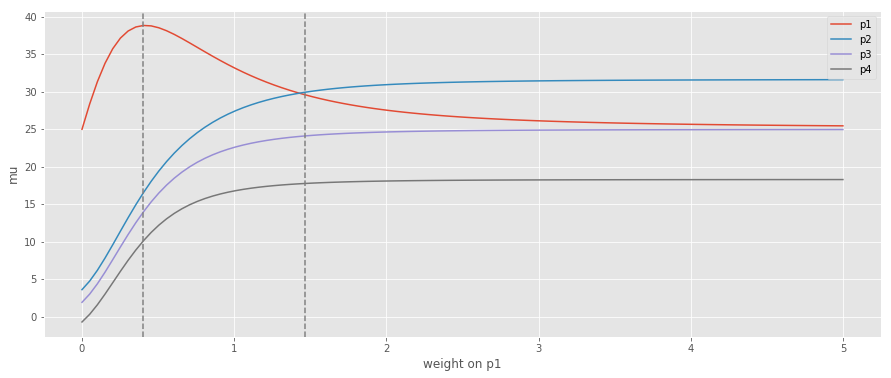

In [147]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)
plt.style.use('ggplot')

x = np.linspace(0.0001, 5, 100)
p1 = [get_test_rating_typeA(xi, init_weights, 0) for xi in x]
p2 = [get_test_rating_typeA(xi, init_weights, 1) for xi in x]
p3 = [get_test_rating_typeA(xi, init_weights, 2) for xi in x]
p4 = [get_test_rating_typeA(xi, init_weights, 3) for xi in x]
plt.plot(x, p1, label='p1')
plt.plot(x, p2, label='p2')
plt.plot(x, p3, label='p3')
plt.plot(x, p4, label='p4')

p1_max = max(p1)
p1_max_idx = [i for i, j in enumerate(p1) if j == p1_max][0]
print(x[p1_max_idx])

plt.axvline(x=x[p1_max_idx], color='Grey', linestyle='--')  # 0.404132323232

p1_p2_cross_idx = ''
for i, j in enumerate(p1):
    if j - p2[i] < 0.001:
        print(x[i])
        p1_p2_cross_idx = i
        break
        
plt.axvline(x=x[p1_p2_cross_idx], color='Grey', linestyle='--')  # 1.46471717172

plt.xlabel('weight on p1')
plt.ylabel('mu')

plt.legend()
plt.show()


###### FFA를 팀 분할로 접근하면?

In [182]:
num_players = 4
player_listB = [[env.Rating(init_mu, init_sigma), env.Rating(init_mu, init_sigma), env.Rating(init_mu, init_sigma)]]
player_listB.append([env.Rating(init_mu, init_sigma)])
player_listB

[[trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=25.000, sigma=8.333)],
 [trueskill.Rating(mu=25.000, sigma=8.333)]]

In [183]:
test_weights = [[1, 1, 1], [1]]
env.rate(rating_groups=player_listB, weights=test_weights)

[(trueskill.Rating(mu=25.047, sigma=8.306),
  trueskill.Rating(mu=25.047, sigma=8.306),
  trueskill.Rating(mu=25.047, sigma=8.306)),
 (trueskill.Rating(mu=24.953, sigma=8.306),)]

In [191]:
def get_test_rating_typeB(my_weight, init_weights, player_index_tuple):
    weights = init_weights
    weights[0][0] = my_weight
    weights[0] = list(np.array(init_weights[0]) / sum(init_weights[0]))
    r = env.rate(rating_groups=player_listB, weights=weights)
    return r[player_index_tuple[0]][player_index_tuple[1]].mu

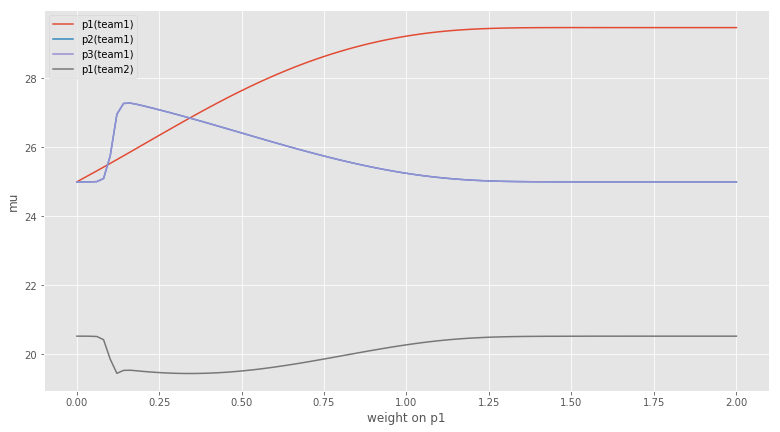

In [192]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams["figure.figsize"] = (13, 7)
plt.style.use('ggplot')

init_weights = [[1, 1, 1], [1]]

x = np.linspace(0.001, 2, 100)
p1 = [get_test_rating_typeB(xi, init_weights, (0, 0)) for xi in x]
p2 = [get_test_rating_typeB(xi, init_weights, (0, 1)) for xi in x]
p3 = [get_test_rating_typeB(xi, init_weights, (0, 2)) for xi in x]
p4 = [get_test_rating_typeB(xi, init_weights, (1, 0)) for xi in x]

plt.plot(x, p1, label='p1(team1)')
plt.plot(x, p2, label='p2(team1)')
plt.plot(x, p3, label='p3(team1)')
plt.plot(x, p4, label='p1(team2)')

plt.xlabel('weight on p1')
plt.ylabel('mu')

plt.legend()
plt.show()

###### FFA의 각 1인팀에 lap time을 mu로 사용하는 가상의 팀원을 더해보면?

In [248]:
dummy_mu = 60
dummy_sigma = 1

player_listC = [[env.Rating(init_mu, init_sigma), env.Rating(mu=dummy_mu, sigma=dummy_sigma)], [env.Rating(init_mu, init_sigma), env.Rating(mu=dummy_mu, sigma=dummy_sigma)], [env.Rating(init_mu, init_sigma), env.Rating(mu=dummy_mu, sigma=dummy_sigma)], [env.Rating(init_mu, init_sigma), env.Rating(mu=dummy_mu, sigma=dummy_sigma)]]
player_listC

[[trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=60.000, sigma=1.000)],
 [trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=60.000, sigma=1.000)],
 [trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=60.000, sigma=1.000)],
 [trueskill.Rating(mu=25.000, sigma=8.333),
  trueskill.Rating(mu=60.000, sigma=1.000)]]

In [249]:
def get_test_rating_typeC(my_lap_time, player_index_tuple):
    weights = [[1, 1], [1, 1], [1, 1], [1, 1]]
    player_listC[0][1] = env.Rating(mu=my_lap_time, sigma=1)
    
    r = env.rate(rating_groups=player_listC, weights=weights)
    return r[player_index_tuple[0]][player_index_tuple[1]].mu

In [250]:
get_test_rating_typeC(100, (0, 0))

25.14639828944672

In [251]:
get_test_rating_typeC(50, (0, 0))

36.30793294069488

In [252]:
np.linspace(2, 1, 5)

array([ 2.  ,  1.75,  1.5 ,  1.25,  1.  ])

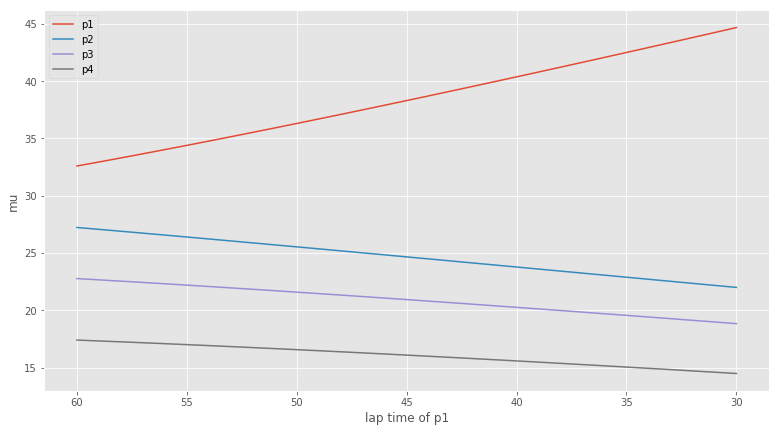

In [253]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams["figure.figsize"] = (13, 7)
plt.style.use('ggplot')

init_weights = [[1, 1, 1], [1]]

x = np.linspace(dummy_mu, dummy_mu/2, 100)
p1 = [get_test_rating_typeC(xi, (0, 0)) for xi in x]
p2 = [get_test_rating_typeC(xi, (1, 0)) for xi in x]
p3 = [get_test_rating_typeC(xi, (2, 0)) for xi in x]
p4 = [get_test_rating_typeC(xi, (3, 0)) for xi in x]

plt.gca().invert_xaxis()
plt.plot(x, p1, label='p1')
plt.plot(x, p2, label='p2')
plt.plot(x, p3, label='p3')
plt.plot(x, p4, label='p4')

plt.xlabel('lap time of p1')
plt.ylabel('mu')

plt.legend()
plt.show()

### copying list of list

In [127]:
class my_class:
    def __init__(self, x):
        self.x = x
    
    def __repr__(self):
        c = type(self)
        return '{}(x={})'.format(c.__name__, self.x)

test1

In [117]:
my_lst = [my_class(1)] * 3

In [118]:
my_lst

[my_class(x=1), my_class(x=1), my_class(x=1)]

In [120]:
my_lst[0] = my_class(2)

In [121]:
my_lst

[my_class(x=2), my_class(x=1), my_class(x=1)]

test2

In [122]:
my_lst = [[my_class(1)]] * 3

In [123]:
my_lst

[[my_class(x=1)], [my_class(x=1)], [my_class(x=1)]]

In [124]:
my_lst[0][0] = my_class(2)

In [125]:
my_lst

[[my_class(x=2)], [my_class(x=2)], [my_class(x=2)]]